<h4><i><font color='red'>The project has many components, and we encourage you to complete as many as you can! That said, we highly encourage you to submit your work even if your notebook is only partially completed - the TA can help review your work and provide tips on any places that you got stuck or have further questions!</font></i></h4>

<font size="6">**Table of Contents:**</font>  
<font size="5">
1\. [Introduction](#scrollTo=alBGiNFLhU8M&uniqifier=1)  
2\. [Setup](#scrollTo=IpnucdoCui0M&uniqifier=1)  
3\. [Exploratory Data Analysis](#scrollTo=3QkLivc3fWvo&uniqifier=1)  
4\. [Simple Feature Preprocessing](#scrollTo=Bv75-bvqgPeg&uniqifier=1)  
5\. [The Key Metric for Candidate Generation: recall@k](#scrollTo=khvwUVsb_x0n&uniqifier=1)  
6\. [Candidate Generation Modeling](#scrollTo=vIDIfwgzhadf&uniqifier=1)</font>  
&emsp;&emsp;&emsp;<font size="4">a\. [Non-Learnt Models](#scrollTo=5Uqtg5rRmmOg&uniqifier=1)</font>  
&emsp;&emsp;&emsp;<font size="4">b\. [Two-Tower Model](#scrollTo=nijeGmCYgU0d&uniqifier=1)</font>  
<font size="5">7\. [TODO 1.1: Create Your Own Non-Learnt Candidate Generators
](#scrollTo=R7u5b2rucahG&uniqifier=1)  
8\. [TODO 1.2: Create Your Own Two-Tower CG (Optional)](#scrollTo=DZQjKKzOlPly&uniqifier=1)

# **1. Introduction**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

## Introduction to Multi-Stage Recommenders

Welcome to the week 1 project of the Personalized Recommendations at Scale course! In this week's project, we’ll look at one key component of a multi-stage recommender system -- the candidate generator.  
<br>
Candidate generation is when the recommendation system takes a large (millions) corpus of content and cuts it down to a small (hundreds or thousands) set of the most relevant items. The model for this stage optimizes for recall because if there’s an option the user might like we want it to be identified here. 

The candidates generated in this phase are then passed to the ranking phase. In the ranking phase, the recommendations are ranked based on how appropriate they are for the user. This stage often involves feeding additional information to the system, like user history and content features. It might also incorporate other candidates' sources, such as new content or time-specific recommendations. The top-k items are then returned and used to populate the recommendation list.  
  
<br>A visualization of what this process looks like is shown below:  

![multi-stage system](https://miro.medium.com/max/1400/1*6LG9QN2XEtK6UCOZG4cavA.png)  
  
## This Week's Topic: Candidate Generation

As introduced above, when trying to recommend items to a user we typically start with a huge catalog of items! As a result our first step is to filter our millions of items into hundreds or thousands of the most relevant items evaluated by [recall as opposed to precision](https://en.wikipedia.org/wiki/Precision_and_recall#:~:text=Recall%20is%20the%20number%20of,documents%20retrieved%20by%20that%20search).  
  
The motivation for this is two-fold:  
1. **Total Latency**: A heavy ranker cannot deal with and rank tens of millions of items fast enough on its own. As such, candidate generators are often referred to as the "light ranker" and remove the need to rank most of the items in the corpus. 
2. **Precision**: Filtering the item corpus down to a small set of the most relevant items can make the heavy ranker's job easier in terms of precision. Ranking the entire corpus, without a candidate generator as a first step, means the most relevant items are not gauranteed to be in the top several hundred or thousand as they would be had you used a candidate generator.
  
<br>  
## About the Data: [H&M's Kaggle](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations) Personalized Fashion Recommendations

In this dataset we are given the purchase history of customers across time, along with supporting metadata. 
* **articles.csv**: Detailed metadata for each article_id available for purchase.
* **customers.csv**: Metadata for each customer_id in dataset.
* **transactions_train.csv**: The training data consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item.  
  
<br>**This notebook benefits from using a GPU!**  
You can use it for free, in Google Colab, by going to the menu bar above, selecting `Runtime`, then `Change runtime type`, then selecting `GPU` as the `Hardware accelerator`.

# **2. Setup**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from tqdm import tqdm
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

In [2]:
# Installs and imports
!pip install -q --upgrade tensorflow-recommenders

import pandas as pd
import numpy as np
import tensorflow_recommenders as tfrs
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from typing import Dict, Text
import random
from collections import Counter
import gc
from tqdm import tqdm
from datetime import timedelta
from IPython.display import clear_output

# Download data
#!pip install -U --no-cache-dir gdown --pre
#!gdown --no-cookies --folder https://drive.google.com/drive/folders/1j9QpkSKwqFfpgohbVxdPDKuwmwJXZ6yz?usp=sharing

#clear_output()

In [7]:
!unzip articles.csv.zip

Archive:  articles.csv.zip
  inflating: articles.csv            


In [8]:
!unzip customers.csv.zip

Archive:  customers.csv.zip
  inflating: customers.csv           


In [9]:
!unzip transactions_train.csv.zip

Archive:  transactions_train.csv.zip
  inflating: transactions_train.csv  


In [10]:
# Read data into memory
article_df = pd.read_csv("articles.csv.zip")
customer_df = pd.read_csv("customers.csv.zip")
transaction_df = pd.read_csv('transactions_train.csv.zip')

In [11]:
article_df.to_parquet('articles.parquet')
customer_df.to_parquet('customers.parquet')
transaction_df.to_parquet('transactions.parquet')

In [209]:
article_df = pd.read_parquet('articles.parquet')
customer_df = pd.read_parquet('customers.parquet')
transaction_df = pd.read_parquet('transactions.parquet')

In [210]:
transaction_df.article_id.nunique()

104547

In [211]:
10/4400

0.0022727272727272726

In [212]:
104547/4400

23.76068181818182

In [213]:
transaction_df.article_id.value_counts(normalize=True).cumsum()[:int(104547*0.002)]

706016001    0.001582
706016002    0.002684
372860001    0.003682
610776002    0.004632
759871002    0.005460
               ...   
827968001    0.071739
684209027    0.071949
179208001    0.072159
621381012    0.072369
408875001    0.072578
Name: article_id, Length: 209, dtype: float64

# **3. Exploratory Data Analysis (EDA)**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

In this section we'll take a dive into the data to understand it better.  
  
<br>We'll first look at the distribution of articles across index names:

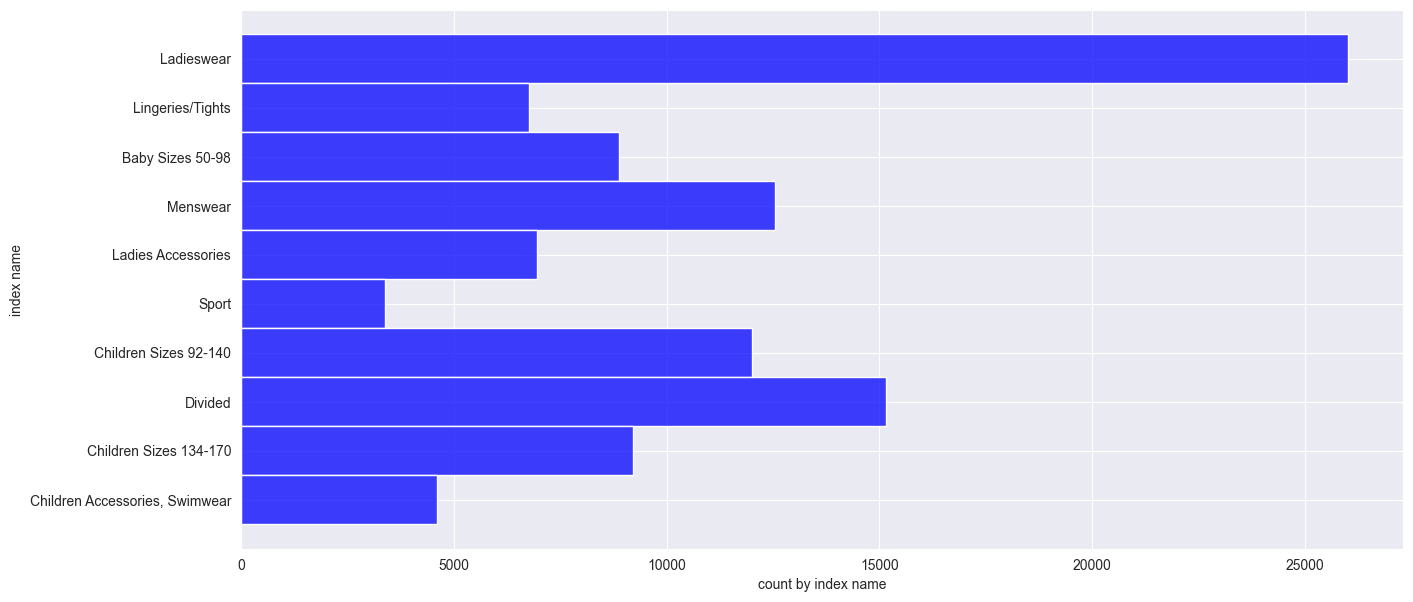

In [214]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=article_df, y='index_name', color='blue')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

We can see that "Ladieswear" is the largest index by a considerable margin, followed by "Divided".  
  
<br>Next let's look at the distribution of garment group names, with a further subdivision of index group name. This gives us an idea of how indices such as ladieswear are distributed within different garment groups. 

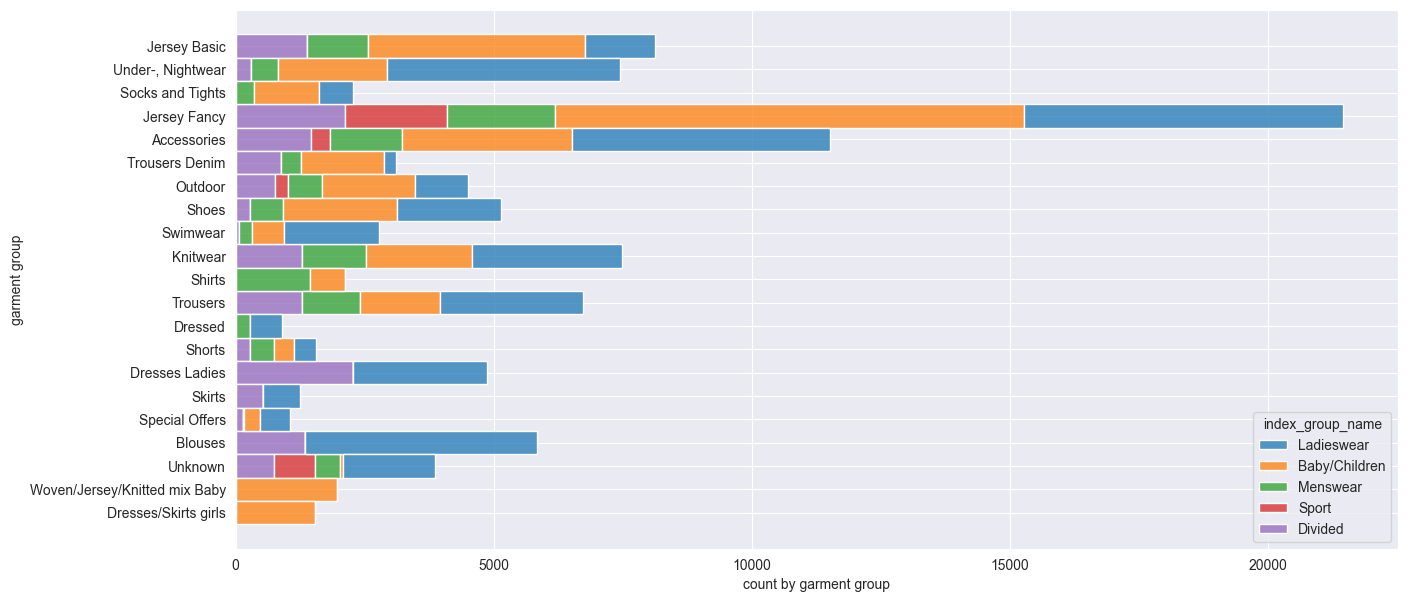

In [215]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=article_df, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

Next, let's look at the distribution of customer age:

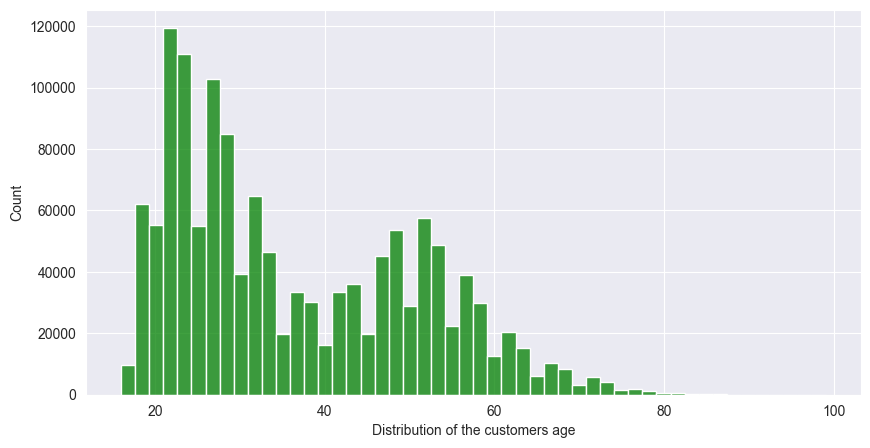

In [216]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customer_df, x='age', bins=50, color='green')
ax.set_xlabel('Distribution of the customers age')
plt.show()

From this plot we could argue there is bimodality present, with a large peak between the ages of 20-30 and a smaller peak at around 50 years old.  
  
<br>Let's now check for how prices are distributed across different product groups. It's worth noting that prices have been preprocessed to be between 0 and 1.

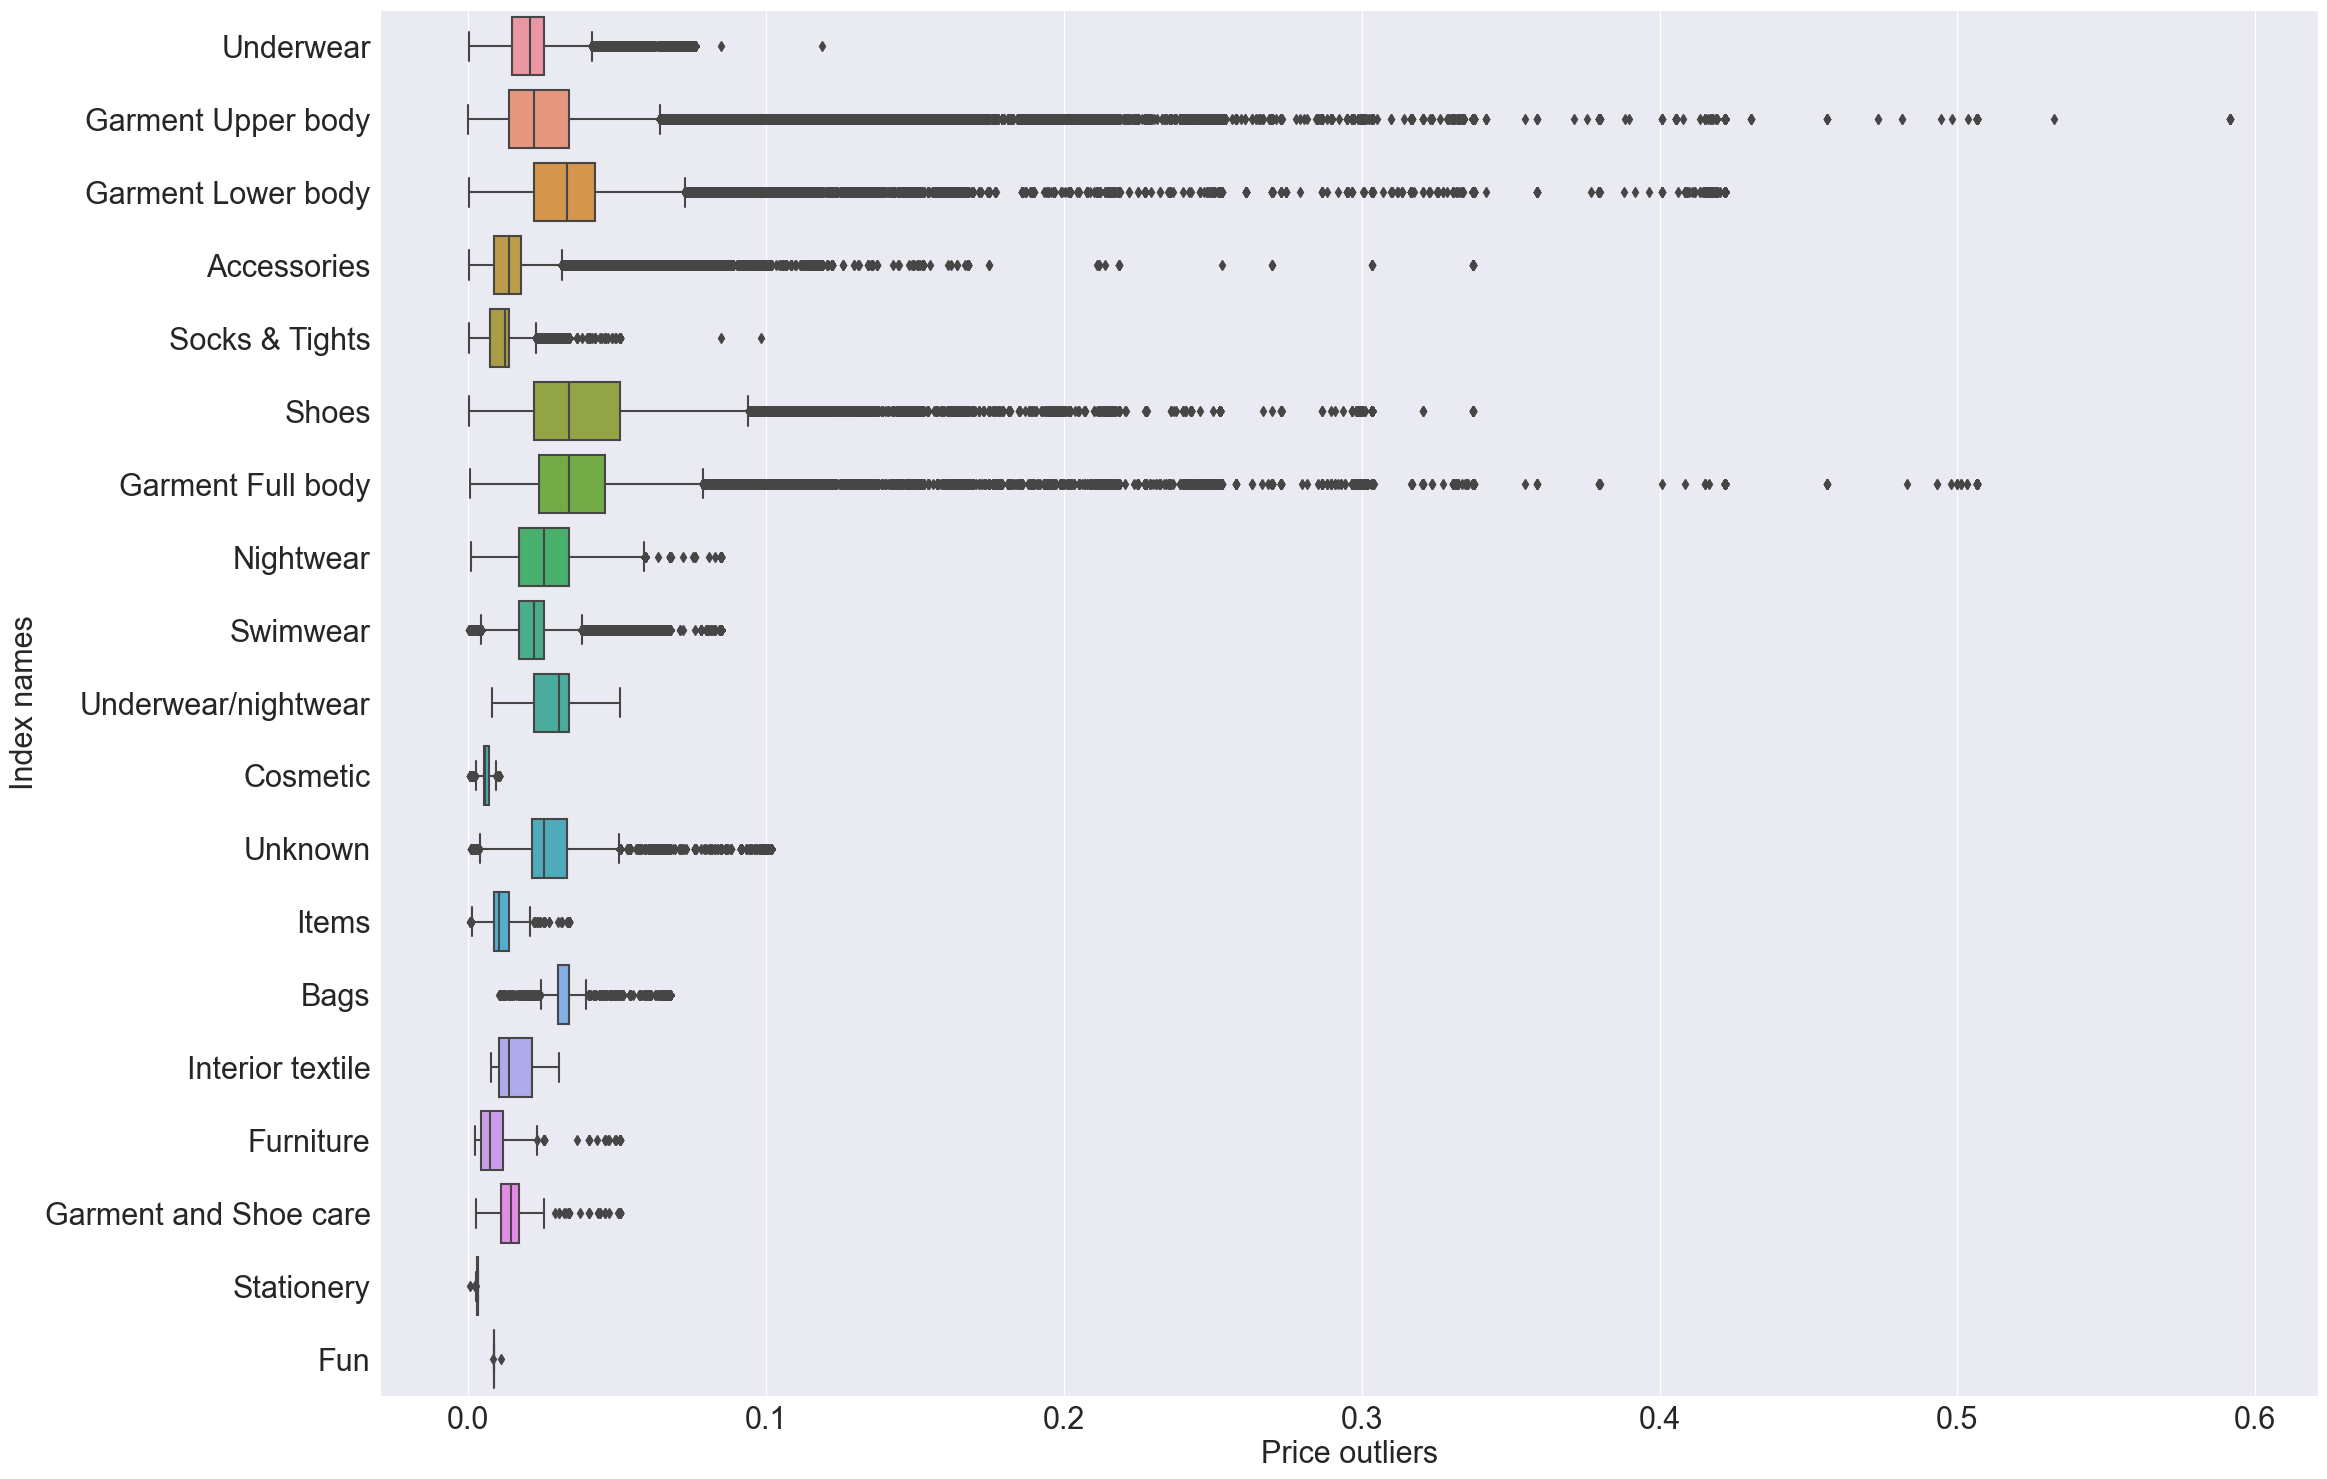

In [217]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(25,18))

# Merge transactions and articles so we relate price and product_group_name
ax = sns.boxplot(data=transaction_df[['article_id', 'price']].merge(article_df[['article_id', 'product_group_name']], on='article_id', how='left'), 
                 x='price', y='product_group_name')

ax.set_xlabel('Price outliers', fontsize=22)
ax.set_ylabel('Index names', fontsize=22)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)
plt.show()

From this plot we can infer that while shoes may have a comparatively high median price it has less extreme price outliers than some more expensive upper body or full body garments. 

# **4. Simple Feature Processing**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

In this section we'll lightly process the features so we can more easily model them.  
  
<br>We'll start with customer data:

In [218]:
# Impute missing data
customer_df["FN"].fillna(0, inplace=True)
customer_df["Active"].fillna(0, inplace=True)
customer_df["club_member_status"].fillna("UNKNOWN", inplace=True)
customer_df["fashion_news_frequency"] = customer_df["fashion_news_frequency"].replace({"None":"NONE"})
customer_df["fashion_news_frequency"].fillna("UNKNOWN", inplace=True)
customer_df["age"].fillna(customer_df["age"].median(), inplace=True)

# Bucket age groups
def create_age_interval(x):
    if x <= 25:
        return [16, 25]
    elif x <= 35:
        return [26, 35]
    elif x <= 45:
        return [36, 45]
    elif x <= 55:
        return [46, 55]
    elif x <= 65:
        return [56, 65]
    else:
        return [66, 99]
customer_df["age_interval"] = customer_df["age"].apply(lambda x: create_age_interval(x))

# Make sure all nulls are filled in customer_df
assert customer_df.isnull().sum().sum() == 0

customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_interval
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,"[46, 55]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,"[16, 25]"
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"[16, 25]"
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,"[46, 55]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,"[46, 55]"


Now we'll process article data:

In [219]:
# Impute missing data
article_df.fillna(value="No Description", inplace=True)

# Change article_id datatype to string
article_df['article_id'] = article_df['article_id'].astype(str)

# Add a zero to the left of the article_id string
article_df['article_id'] = article_df['article_id'].apply(lambda x: x.zfill(10))

article_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


And finally we'll apply the same transformation from articles above to the corresponding article_ids in the transactions dataset:

In [220]:
transaction_df['article_id'] = transaction_df['article_id'].astype(str)
transaction_df['article_id'] = transaction_df['article_id'].apply(lambda x: x.zfill(10))

transaction_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


# **5. The Key Metric for Candidate Generation: recall@k**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

The goal of the candidate generator is to fetch enough relevant candidates for the ranker to rank.If the candidate generator does this well, the ranker can do a better job at ranking these candidates. However, if the candidate generator misses out on a large set of relevant items, the ranker cannot rank them since it doesn't have access to good candidate items.

Given such a role of the candidate generator, recall becomes the key metric with which we evaluate different candidate generators. _Recall@k_ is the proportion of relevant items found in the top-k selected candidates.
  
<br>Mathematically, it's defined as follows:  
_Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)_
  
<br>For example, suppose we have a user who will make 5 purchases next month and we wish to make 10 recommendations to this user on the homepage from among the set of 1 million products. Further suppose we have two candidate generators (CG-A and CG-B), each returning 100 candidates that the ranker can consume and select the top 10 recommendations. If CG-A is able to retrieve 3 of these 5 products amongst its set of 100 candidates, and CG-B is able to retrieve only 2 of the 5 products amongst its set of 100 candidates, then CG-A would have a higher recall than CG-B.
Recall for CG-A = 3/5
Recall for CG-B = 2/5
  
<br>Let's implement this recall metric in a simple function and try it out.

In [221]:
# Intersection helper function 
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

# Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
def estimate_recall(cg, purchase):
    return len(intersection(cg,purchase))/len(purchase)


# Test the functions with toy example. 
# How many items from purchases did each CG retrieve?
purchases = ["item45","item97","item71","item125","item5"]
cg1 = ["item1","item97","item12","item105","item5","item17","item197","item122","item85","item15"]
cg2 = ["item13","item94","item14","item15","item5","item18","item197","item132","item86","item65"]

print("recall for CG1: ", estimate_recall(cg1, purchases))
print("recall for CG1: ", estimate_recall(cg2, purchases))

recall for CG1:  0.4
recall for CG1:  0.2


# **6. Candidate Generation Modeling**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

Now that we can evaluate a candidate generator, let's take a look at a few! We'll start with non-learnt candidate generators, which are have no loss function/objective to optimize for.
  
> **1. Candidate Generator 1: Random products**  
The simplest candidate generator to start with is a random candidate selector -- from amongst the list of products, randomly select products.


> **2. Candidate Generator 2: Most popular products**  
Another simple candidate selection strategy is to select the top-k most popular products from historic interactions and use this list as the set of candidates for the downstream ranking goal.
  
<br>In order to have a clean evaluation set-up, we will divide the transactions data into train and test split. We use the last week of transactions as the test set (as was done in the [original competition](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/overview/evaluation)) and the preceding 6 weeks as the training set (as was done in the [1st place submission](https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/discussion/324070)). Feel free to change these values.  
  
<br>Below we will implement these two candidate generators and compare their recall performace:

In [222]:
# Split transactions into train and test
N_DAYS_TRAIN = 45
N_DAYS_TEST = 7

max_date = transaction_df['t_dat'].max()
train = transaction_df[(transaction_df['t_dat']>=((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TRAIN+N_DAYS_TEST)).date().strftime('%Y-%m-%d')))
                        & (transaction_df['t_dat']<((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TEST)).date().strftime('%Y-%m-%d')))]
test = transaction_df[(transaction_df['t_dat']>=((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TEST)).date().strftime('%Y-%m-%d')))]


# Delete transaction_df from the namespace to free up some memory
transaction_df = None
del transaction_df
gc.collect()

train.shape, test.shape

((1769097, 5), (266364, 5))

For ease of evaluation, without any loss of generalization, we only consider customers that have made a purchase in both train and test time-periods. We'll label them `common_users`. The methods and set-up remain the same for all other customers as well.

In [223]:
c1 = train['customer_id'].to_list()
c2 = test['customer_id'].to_list()

# Note: Sorting common_users so evaluation is deterministic
common_users = sorted(intersection(c1, c2))

print(len(train), len(test), len(c1), len(c2), len(common_users))

1769097 266364 1769097 266364 42395


## **6a. Non-Learnt Models**
[back to top](#scrollTo=M2t2RSi5gOuE&line=2&uniqifier=1)

Candidate Generator 1: Random products

In [224]:
# Pre-calculate unique items so they can be re-used during every invocation
train_unique_items = sorted(train['article_id'].unique().tolist())

def get_k_candidates_random(u, k):
    """
    Generate k random candidates from the training set.

    Args:
        u (str): user ID for which to generate the candidates.
        k (int): Number of candidates to generate.

    Returns:
        candidates (list): Random k candidates. 
    """

    # Set the seed to the user ID to make this function deterministic
    random.seed(u)
    candidates = random.sample(train_unique_items, k)
    return candidates

Candidate Generator 2: Most popular products

In [225]:
# Pre-calculate item counts so they can be re-used during every invocation
train_item_counts = Counter(train['article_id'].to_list()).most_common()

def get_top_k_candidates_popular(u, k):
    """
    Generate k most popular (number of times purchased) candidates from the training set.

    Args:
        u (str): user ID for which to generate the candidates. Not necessary for this function, but is an assumed input during evaluation. 
        k (int): Number of candidates to generate.

    Returns:
        candidates (list): The most popular k candidates. 
    """
    candidates = [article for article, count in train_item_counts[:k]]
    return candidates

Below we implement a function to assess the recall of our candidate generators. For speed of computation we test with only 100 users but feel free to increase this as your time and RAM allow. 

In [258]:
def run_candidate_generation(method, k_values=[100,1000], user_set_size=1000):
    """
    Evaluate a given candidate generator in terms of recall on the held-out test set.

    Args:
        method (function): Candidate generation function. User ID (u) and number of candidates (k) arguments.
        k_values (list): List of number of candidates to generate and evaluate.
        user_set_size (int): Number of users to evaluate.

    Returns:
        None. Prints results.
    """

    # Initialise evaluation variables
    k_values = sorted(k_values)
    recall_dict = {k:0 for k in k_values}    
    user_set = common_users[:user_set_size]

    # Loop over users
    for u in tqdm(user_set):
        # Get list of purchased items for user u
        purchase_list = test[test['customer_id']==u]['article_id'].to_list()
        # Run candidate generation
        cg = method(u, max(k_values))
        for k in k_values:
            # Estimate recall for candidate generator
            recall = estimate_recall(cg[:k], purchase_list)
            # Add this to overall recall (to be averaged at end)
            recall_dict[k] += recall

    print(f"\nRecall evaluation for {user_set_size:,} users:")
    for k in k_values:
        # Average recall by dividing sum of recalls by user_set length
        overall_recall = recall_dict[k] / len(user_set)
        print(f"Recall @ {k} Candidates: {overall_recall:.5f}")

In [227]:
# Evaluate CG 1 (random)
run_candidate_generation(get_k_candidates_random)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.09it/s]


Recall evaluation for 100 users:
Recall @ 100 Candidates: 0.00259
Recall @ 1000 Candidates: 0.01515


In [228]:
# Evaluate CG 2 (popularity)
run_candidate_generation(get_top_k_candidates_popular)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 63.51it/s]


Recall evaluation for 100 users:
Recall @ 100 Candidates: 0.09398
Recall @ 1000 Candidates: 0.31827


We notice that the recall@k metric is significantly higher for the popular CG than for the random CG, which is in line with our expectations.

Both of these CGs are non-learnt and generic across all users. We'll now discuss a learnt CG model -- the two-tower model which we covered in lecture.

## **6b. Two-Tower Model**
[back to top](#scrollTo=M2t2RSi5gOuE&line=2&uniqifier=1)

The [two tower model](https://corise.com/course/personalized-recommendation-at-scale/v2/module/modern-recommender-systems) is a neural network that is made up of two separate sub-models, one that learns representations for the users, and one that learns representations for candidates or items. These representations are then multiplied in a dot product to produce a prediction of whether a user will like an item. This is currently one of the best-performing models for candidate generation, as it learns information from both users and items. Below you can see a visualization of how this process works:  
  
> **3. Candidate Generator 3: Two-tower model**  
One of most popular, and industry-wide used CGs is a two-tower neural network. This is a learnt deep model with one tower for the user and another tower for the product, followed by a dot product.

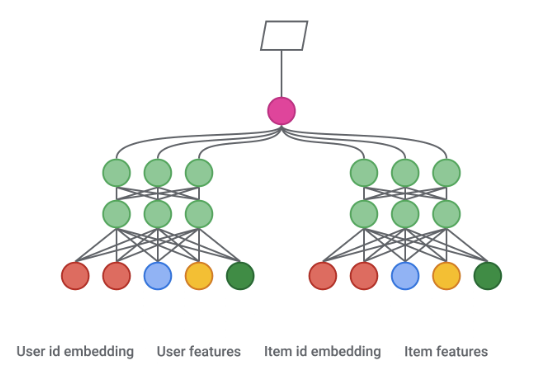  
  
<br>This approach is useful for candidate generation across a wide variety of industries, from online retail to social media! With one tower representing the users and the other representing the items, the system can learn a lot about whether a user might like a particular item. These models are trained using implicit signals – YouTube, for example, might consider how many seconds a user streamed a video, or how they interacted with it. The learned information can then be combined to produce the final prediction.  
  
<br>First we will generate a list of unique customer and article ids which we will use to create our vocabulary for our [StringLookup layer](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup/) which offers a really convenient way for us to pass a vocabulary to an [Embedding layer](https://keras.io/api/layers/core_layers/embedding/).

In [229]:
# Create lists of unique ids
unique_customer_ids = train.customer_id.unique()
unique_article_ids = train.article_id.unique()

We now generate our customer model (the customer tower) and the article model (the article tower). Feel free to play around with the size of the embedding dimension and the architecture!

In [230]:
all_data = pd.concat([train, test], axis=0)

In [231]:
train

,t_dat,customer_id,article_id,price,sales_channel_id
29752863,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,0743123001,0.011847,2
29752864,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,0743123001,0.011847,2
29752865,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,0849597003,0.012186,2
29752866,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,0599580052,0.016932,2
29752867,2020-08-01,00075ef36696a7b4ed8c83e22a4bf7ea7c90ee110991ec...,0599580052,0.016932,2
...,...,...,...,...,...
31521955,2020-09-14,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,0859737002,0.025407,1
31521956,2020-09-14,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,0573085028,0.033881,1
31521957,2020-09-14,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,0745686008,0.030492,1
31521958,2020-09-14,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,0821398001,0.016932,1


In [232]:
article_features = ['article_id','product_type_name','product_group_name','colour_group_name','index_name',
                    'detail_desc', 'graphical_appearance_name', 'garment_group_name', 'index_group_name']
all_data = all_data.merge(article_df[article_features], on='article_id')
all_data = all_data.merge(customer_df[['customer_id', 'age']], on='customer_id')

In [233]:
all_data.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'product_type_name', 'product_group_name', 'colour_group_name',
       'index_name', 'detail_desc', 'graphical_appearance_name',
       'garment_group_name', 'index_group_name', 'age'],
      dtype='object')

In [234]:
def create_prev_items_col(transactions_df, no_history_value = 'no_disc'):

    z = transactions_df
    z['prev_items_desc'] = z.groupby('customer_id')['detail_desc'].progress_apply(lambda x:
                                                                                x.shift(1, fill_value='') + ' ' +
                                                                                x.shift(2, fill_value='') + ' ' +
                                                                                x.shift(3, fill_value='') + ' ' +
                                                                                x.shift(4, fill_value=''))
    z['prev_items_desc'] = z.prev_items_desc.apply(lambda concat_desc: concat_desc.strip())
    z['prev_items_desc'] = z.prev_items_desc.apply(lambda x: no_history_value if len(x) == 0 else x)
    return z

In [235]:
def create_prev_articles_col(transactions_df, no_history_value = 'first_article'):

    z = transactions_df
    z['prev_articles'] = z.groupby('customer_id')['article_id'].progress_apply(lambda x:
                                                                               x.shift(1, fill_value='') + ' ' +
                                                                               x.shift(2, fill_value='') + ' ' +
                                                                               x.shift(3, fill_value='') + ' ' +
                                                                               x.shift(4, fill_value=''))
    z['prev_articles'] = z.prev_articles.apply(lambda concat_chains: concat_chains.strip())
    z['prev_articles'] = z.prev_articles.apply(lambda x: no_history_value if len(x) == 0 else x)
    return z

In [236]:
def add_candidate_sampling_probabilities(df, candidate_id_col):

    print('data before calc probability', df.shape)
    s = df[candidate_id_col].value_counts(normalize=True).reset_index()
    s = s.rename(columns={'index': candidate_id_col, candidate_id_col: 'candidate_probability'})
    s['candidate_probability'] = s['candidate_probability'].astype('float32')
    df = df.merge(s, on=candidate_id_col, how='left')
    print('data after calc probability', df.shape)
    return df

In [237]:
all_data = create_prev_items_col(all_data)
all_data = create_prev_articles_col(all_data)

  0%|          | 0/363798 [00:00<?, ?it/s]

  0%|          | 0/363798 [00:00<?, ?it/s]

In [238]:
all_data = add_candidate_sampling_probabilities(all_data, 'article_id')

data before calc probability (2035461, 16)
data after calc probability (2035461, 17)


In [239]:
all_data['detail_desc'] = all_data['detail_desc'].apply(lambda x : x.strip().replace('.','').replace(',','').lower())
all_data['prev_items_desc'] = all_data['prev_items_desc'].apply(lambda x : x.strip().replace('.','').replace(',','').lower())

In [240]:
all_words = {word.lower() for desc in  all_data['detail_desc'].values for word in desc.split()}
all_words = list(all_words)
unique_words = all_words

In [241]:
len(all_words)

3105

In [242]:
class customerModel(tf.keras.Model):
    def __init__(self, user_embedding_size, unique_customer_ids, unique_article_ids,
                 item_desc_vocab, item_desc_shared_embedding, 
                 article_shared_embedding, query_features):
        super().__init__()
        self.feat_to_partial_tower = {}
        if 'customer_id' in query_features:
            self.account_embedding = tf.keras.Sequential([
              tf.keras.layers.StringLookup(
                  vocabulary=unique_customer_ids, mask_token=None, name='customer_lookup'),
              tf.keras.layers.Embedding(len(unique_customer_ids) + 1, user_embedding_size,
                                        name='account_embedding')
            ])
            self.feat_to_partial_tower['customer_id'] = self.account_embedding
        
        if 'prev_articles' in query_features:


            self.articles_vectorizer = tf.keras.layers.TextVectorization(vocabulary=list(unique_article_ids),
                                                                         standardize='strip_punctuation')
            articles_agg = tf.keras.layers.GlobalAveragePooling1D()
                
            self.prev_articles_embedding = tf.keras.Sequential([
                self.articles_vectorizer,
                article_shared_embedding,
                articles_agg,
            ])
            self.feat_to_partial_tower['prev_articles'] =  self.prev_articles_embedding
        
        if 'prev_items_desc' in query_features:


            self.item_desc_vectorizer = tf.keras.layers.TextVectorization(vocabulary=list(item_desc_vocab),
                                                                          standardize='strip_punctuation')
            desc_agg = tf.keras.layers.GlobalAveragePooling1D()
                
            self.prev_items_desc_embedding = tf.keras.Sequential([
                self.item_desc_vectorizer,
                item_desc_shared_embedding,
                desc_agg,
            ])
            self.feat_to_partial_tower['prev_items_desc'] =  self.prev_items_desc_embedding
        
        

    def call(self, features_df):
        potential_features = ['prev_items_desc', 'prev_articles', 'customer_id']
        if len(self.feat_to_partial_tower) > 1:
            available_features = [feature for feature in potential_features if feature in features_df]
            output = tf.concat([
                self.feat_to_partial_tower[feature](features_df[feature]) for feature in available_features
            ], axis=1)
        else:
            output = self.account_embedding(features_df['account_id'])

        return output

In [243]:
class articleModel(tf.keras.Model):
    def __init__(self, article_shared_embedding, unique_articles_ids, 
                 item_desc_shared_embedding, item_desc_vocab, candidates_features):

        super().__init__()

        
        if 'article_id' in candidates_features:
            self.chain_embedding = tf.keras.Sequential([
              tf.keras.layers.StringLookup(
                  vocabulary=unique_articles_ids, mask_token='0', name='chain_lookup'),
                article_shared_embedding
            ])
        self.feat_to_partial_tower = {'article_id': self.chain_embedding}
        if 'detail_desc' in candidates_features:
            self.desc_vectorizer = tf.keras.layers.TextVectorization(
                vocabulary=list(item_desc_vocab),
                standardize='lower_and_strip_punctuation')

            self.desc_text_embedding = tf.keras.Sequential([
                self.desc_vectorizer,
                item_desc_shared_embedding,
                tf.keras.layers.GlobalAveragePooling1D(),
            ])
            self.feat_to_partial_tower['detail_desc'] = self.desc_text_embedding
        

    def call(self, chains_df):

        potential_features = ['article_id', 'detail_desc']

        if len(self.feat_to_partial_tower) > 1:
            available_features = [feature for feature in potential_features if feature in chains_df]
            output = tf.concat([
                self.feat_to_partial_tower[feature](chains_df[feature]) for feature in available_features
            ], axis=1)
        else:
            output = self.chain_embedding(chains_df['article_id'])
        return output

In [119]:
article_embedding_size = 16
item_desc_embedding_size = 16
user_embedding_size = 16

In [120]:
article_shared_embedding = tf.keras.layers.Embedding(len(unique_article_ids)+2, article_embedding_size, mask_zero=True)
item_desc_shared_embedding = tf.keras.layers.Embedding(len(unique_words)+2, item_desc_embedding_size, mask_zero=True)

In [121]:
article_shared_embedding, item_desc_shared_embedding

(<keras.layers.core.embedding.Embedding at 0x41471a100>,
 <keras.layers.core.embedding.Embedding at 0x41471a1c0>)

In [122]:
candidates_features = ['article_id', 'detail_desc']
query_features = ['prev_items_desc', 'prev_articles', 'customer_id']
test_retrieval_features = candidates_features + query_features
train_retrieval_features = test_retrieval_features + ['candidate_probability'] 
test_candidate_features = candidates_features
train_candidates_features = candidates_features + ['candidate_probability'] 


In [136]:
normalization = tf.keras.layers.Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=-1))
customer_model = tf.keras.Sequential([
    customerModel(user_embedding_size, unique_customer_ids, unique_article_ids,
                               unique_words, item_desc_shared_embedding, 
                               article_shared_embedding, query_features),
    tf.keras.layers.Dense(article_embedding_size * 2, activation='relu'),
    normalization])

article_model = tf.keras.Sequential([
        articleModel(article_shared_embedding, unique_article_ids,  
                     item_desc_shared_embedding, unique_words, candidates_features),
        
        tf.keras.layers.Dense(article_embedding_size * 2, activation='relu'),
        normalization])

In [137]:
def get_candidates_dataset(train_df, features_cols):

    unique_chains_df = train_df[features_cols].drop_duplicates()
    candidates_ds = tf.data.Dataset.from_tensor_slices(dict(unique_chains_df))
    candidates_ds = candidates_ds.map(lambda features: {col: features[col] for col in features_cols})
    return candidates_ds

In [247]:
N_DAYS_TRAIN = 45
N_DAYS_TEST = 7

max_date = all_data['t_dat'].max()
train = all_data[(all_data['t_dat']>=((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TRAIN+N_DAYS_TEST)).date().strftime('%Y-%m-%d')))
                        & (all_data['t_dat']<((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TEST)).date().strftime('%Y-%m-%d')))]
test = all_data[(all_data['t_dat']>=((pd.to_datetime(max_date) - timedelta(days=N_DAYS_TEST)).date().strftime('%Y-%m-%d')))]

In [139]:
candidates_features

['article_id', 'detail_desc']

In [140]:
candidates_ds = get_candidates_dataset(train, candidates_features)

In [141]:
for i in candidates_ds:
    print(i)
    break

{'article_id': <tf.Tensor: shape=(), dtype=string, numpy=b'0743123001'>, 'detail_desc': <tf.Tensor: shape=(), dtype=string, numpy=b'bikini top with underwired moulded lightly padded cups ties at the back of the neck and a metal fastener at the back'>}


We will convert our pandas dataframes into [tensorflow datasets](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) as they are easier to use with Keras. 


Now we can formally place our `customer_model` and `article_model` towers into a trainable class, which Tensorflow Recommenders expects. We'll be inheriting from `tfrs.Model` and using the special [tfrs.tasks.Retrieval](https://www.tensorflow.org/recommenders/api_docs/python/tfrs/tasks/Retrieval) task, which allow us to abstract away much of the boilerplate in training this model. 
  
<br>If you want to know more you can visit this [example](https://www.tensorflow.org/recommenders/examples/basic_retrieval) and the associated documentation. We'll be using the [tfrs.metrics.FactorizedTopK](https://www.tensorflow.org/recommenders/api_docs/python/tfrs/metrics/FactorizedTopK) metric to monitor model training, which calculates how often the true candidate is in the top K candidates for a given query. Note that this is quite computationally expensive to run as, by default, this metric will use every other article besides the "true" purchased article and run it through the article model. For this reason we only calculate this metric when evaluating the model.

In [142]:
class HandMModel(tfrs.Model):
    
    def __init__(self, customer_model, article_model, temperature, query_features, candidates_features):
        super().__init__()
        self.article_model: tf.keras.Model = article_model
        self.customer_model: tf.keras.Model = customer_model
        self.task = tfrs.tasks.Retrieval(
            metrics=tfrs.metrics.FactorizedTopK(
            candidates=candidates_ds.batch(128).map(self.article_model), 
                # Batching articles into size 128 and passing through the article model           
            ),
            remove_accidental_hits=True,
            temperature=temperature,
        )
        self.query_features = query_features
        self.candidate_features = candidates_features
        

    def compute_loss(self, features, training=False):
        print(features)
        print(list(features.keys()))
        customer_embeddings = self.customer_model({
            a: features[a] for a in self.query_features
        })    
        article_embeddings = self.article_model({
            a: features[a] for a in self.candidate_features
        })
        candidate_probability = features['candidate_probability']
        candidate_ids = features['article_id']

        # The task computes the loss and the metrics.
        # Note that by default compute_metrics is set to not_training as running during training is VERY expensive
        return self.task(customer_embeddings, article_embeddings, compute_metrics=not training,
                         candidate_sampling_probability=candidate_probability,
                         candidate_ids=candidate_ids,)

After defining the model, we can use standard Keras fitting and evaluation routines.

Let's first instantiate the model:

In [143]:
article_model.layers

In [144]:
candidates_features

['article_id', 'detail_desc']

In [150]:
# Instantiate model
temperature = 0.1
train_batch = 1024
model = HandMModel(customer_model, article_model, temperature=temperature,
                  query_features=query_features, candidates_features=candidates_features)
model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1))

Then let's shuffle, batch, and cache the train and test split, and then train the model on the training data.

In [151]:
ds = tf.data.Dataset.from_tensor_slices(
            dict(
                train[train_retrieval_features]
            ))

In [ ]:

class OrderLevelRecallatK(tf.keras.callbacks.Callback):
        def __init__(self, k, geo_to_chains, geo_to_parent_geo, test_df,
                     query_features, candidate_features, account_prev_interactions,
                     order_level_eval=True):

            self.k = k
            ## to get the chains that can deliver to a particular user
            self.geo_to_chains = geo_to_chains
            self.geo_to_parent_geo = geo_to_parent_geo

            ## select most frequent k chains
            #x = agg_user_interactions.chains.apply(lambda x: len(x)).sort_values(ascending=False)
            #x = x / x.sum()
            #self.sample_agg_users = agg_user_interactions.loc[x[:10000].index.values]
            ## to get needed features for test set

            self.test_df = test_df
            self.query_features = query_features
            self.candidate_features = candidate_features
            self.account_prev_interactions = account_prev_interactions
            self.order_level_eval = order_level_eval
            self.recall_list = {}
            self.chain_to_name = {a: b for a, b in zip(test_df.chain_id.values, test_df.chain_name.values)}

        def on_train_begin(self, logs=None):

            print(f'TRAINING STARTED | Dollar is falling\n')

        def on_epoch_end(self, epoch, logs=None):
            if epoch % 3 == 0 or epoch in range(10):
                if self.order_level_eval:
                    self.compute_embeddings_dynamic_features()
                    self.evaluate_tower_on_orders(epoch=epoch, account_prev_interactions=self.account_prev_interactions)

                else:
                    # print('Embedding Eval @Epoch',epoch)
                    # self.compute_embeddings()
                    # self.evaluate_embedding_on_sample()
                    print('Tower Eval @Epoch', epoch)
                    self.compute_embeddings_dynamic_features()
                    self.evaluate_tower_on_sample(epoch=epoch)

            if epoch >= 5:
                if self.recall_list['recall@10'][-1] < 0.5:
                    self.model.stop_training = True

            if epoch == 1:
                recall_lst = self.recall_list['recall@10']
                if recall_lst[0] > recall_lst[1] and recall_lst[1] < 0.5:
                    self.model.stop_training = True
            if epoch == 2:
                last_recall = self.recall_list['recall@50'][-1]
                if last_recall < 0.5:
                    self.model.stop_training = True

            if epoch > 3:
                last_epochs = self.recall_list['recall@50'][-3:]
                if last_epochs[0] > last_epochs[1] > last_epochs[2]:
                    self.model.stop_training = True


        def compute_embeddings_dynamic_features(self):

            first_order_df = self.test_df
            ## rank the orders per user ascending using time
            first_order_df['rank'] = first_order_df.sort_values(['order_time_utc', 'account_id'],
                                                                ascending=[True, False]) \
                                         .groupby(['account_id']) \
                                         .cumcount() + 1
            # keep only the first order in the test set
            # as if we're building the embedding using the first order features
            first_order_df = first_order_df.query('rank == 1')

            assert first_order_df.account_id.value_counts().max() == 1
            a_model = self.model.customer_model
            user_features = first_order_df[self.query_features].drop_duplicates()
            user_embeddings_np = a_model(user_features).numpy()
            user_embeddings = pd.DataFrame(data={'account_id': user_features.account_id.unique(),
                                                 'account_embeddings': list(user_embeddings_np)})

            self.user_embeddings = user_embeddings.set_index('account_id')

            c_model = self.model.chain_model
            unique_chains = self.test_df[self.candidate_features].drop_duplicates()
            chain_embeddings_np = c_model(unique_chains).numpy()
            chain_embeddings = pd.DataFrame(data={'chain_id': unique_chains.chain_id,
                                                  'chain_embeddings': list(chain_embeddings_np)})
            self.chain_embeddings = chain_embeddings.set_index('chain_id')

        def evaluate_tower_on_orders(self, epoch, account_prev_interactions):

            reorder_count = 0
            new_order_count = 0
            recall_dict = {}
            orders_count = 0
            errors = 0
            total_displayed = 0
            customer_model = self.model.customer_model
            sample_test_orders = self.test_df.sample(10000)
            model_features = sample_test_orders[self.query_features]
            coverage = {}
            print(model_features.head())
            sample_query_embeddings = customer_model(model_features).numpy()
            print('evaluating on ', sample_test_orders.shape[0]/self.test_df.shape[0], '% of test data')
            for i, order in tqdm(enumerate(sample_test_orders.itertuples()), total=sample_test_orders.shape[0]):
                try:
                    #account_id = order.account_id
                    geohash = order.geohash
                    chain_id = order.chain_id
                    account_id = order.account_id
                    chain_name = order.chain_name
                    query_embeddings = sample_query_embeddings[i]
                    prev_chains = account_prev_interactions[account_id]
                    # old_chains = self.account_prev_interactions[account_id]
                    # TODO this supposed to be
                    available_chains = list(self.geo_to_chains[self.geo_to_parent_geo[geohash]])
                    available_chains_w_embedding = [str(x) for x in available_chains if str(x)
                                                    in self.chain_embeddings.index]
                    # available_chains_w_embedding_wo_old = [x for x in available_chains_w_embedding if x not in old_chains]
                    # new_chains = [ch for ch in chains if ch not in old_chains]
                    # reorder_chains = [ch for ch in chains if ch in old_chains]
                    # TODO: handle the following line better
                    if chain_id not in available_chains_w_embedding:
                        errors += 1
                        continue
                    # chains = [chain for chain in chains if chain in available_chains_w_embedding]
                    if chain_id not in prev_chains:
                        # remove old chains from the comparison
                        available_chains_w_embedding = [chain for chain in available_chains_w_embedding
                                                        if chain not in prev_chains]

                    chains_embeddings = self.chain_embeddings.loc[available_chains_w_embedding].values
                    chains_embeddings = np.array([np.array([x for x in y]) for y in chains_embeddings]).squeeze()
                    account_embeddings = query_embeddings



                    sim_score = get_embeddings_similarity(account_embeddings, chains_embeddings)
                    # sim_score = account_embeddings.dot(chains_embeddings.T)
                    # sim_score = sim_score / np.linalg.norm(sim_score)
                    chain_order = np.argsort(sim_score)[::-1]
                    sorted_chains = np.array(available_chains_w_embedding)[chain_order]
                    unique_sorted_chains = [self.chain_to_name[chain_id] for chain_id in sorted_chains]
                    unique_sorted_chains = remove_redundant_values(unique_sorted_chains)

                    if np.random.rand()< 0.01 and total_displayed <=5:
                        top10_recommendations = np.array(available_chains_w_embedding)[chain_order[:20]]
                        for i in range(20):
                            coverage[i+1] = coverage.get(i+1, set()).intersection(top10_recommendations[i])
                        self.display_recommendation(order, top10_recommendations)
                        total_displayed += 1
                    for k in self.k:
                        retrieved_chains = np.array(available_chains_w_embedding)[chain_order[:k]]
                        retrieved_names = np.array(unique_sorted_chains)[:k]
                        recall_k = 1 if chain_id in retrieved_chains else 0
                        name_recall_k = 1 if chain_name in retrieved_names else 0
                        if chain_id not in prev_chains:
                            recall_dict[f'new_recall@{k}'] = recall_dict.get(f'new_recall@{k}', 0) + recall_k

                        else:
                            recall_dict[f'reorder_recall@{k}'] = recall_dict.get(f'reorder_recall@{k}', 0) + recall_k
                        recall_dict[f'recall@{k}'] = recall_dict.get(f'recall@{k}', 0) + recall_k
                        recall_dict[f'fair_recall@{k}'] = recall_dict.get(f'fair_recall@{k}', 0) + name_recall_k
                    if chain_id not in prev_chains:
                        new_order_count += 1
                    else:
                        reorder_count += 1
                    orders_count += 1
                except Exception:
                    errors += 1

            print('errors', errors, 'percentage', errors/sample_test_orders.shape[0]*100)
            for k in self.k:
                recall_k = recall_dict[f'recall@{k}'] / (sample_test_orders.shape[0] - errors)
                reorder_recall_k = recall_dict[f'reorder_recall@{k}'] / reorder_count
                new_order_recall_k = recall_dict[f'new_recall@{k}'] / new_order_count
                fair_recall_k = recall_dict[f'fair_recall@{k}'] / (sample_test_orders.shape[0] - errors)
                print(f"recall@{k}: {recall_k}")
                print(f"new_recall@{k}: {new_order_recall_k}")
                print(f"reorder_recall@{k}: {reorder_recall_k}")
                print(f"fair_recall@{k}: {fair_recall_k}")
                tf.summary.scalar(f'recall@{k}', recall_k, step=epoch)
                tf.summary.scalar(f'reorder_recall@{k}', reorder_recall_k, step=epoch)
                tf.summary.scalar(f'new_recall@{k}', new_order_recall_k, step=epoch)
                self.recall_list[f'recall@{k}'] = self.recall_list.get(f'recall@{k}', []) + [recall_k]
                self.recall_list[f'new_recall@{k}'] = self.recall_list.get(f'new_recall@{k}', []) + \
                                                      [new_order_recall_k]
                self.recall_list[f'reorder_recall@{k}'] = self.recall_list.get(f'reorder_recall@{k}', []) + \
                                                          [reorder_recall_k]
                self.recall_list[f'fair_recall@{k}'] = self.recall_list.get(f'fair_recall@{k}', []) + \
                                                           [fair_recall_k]

        def get_recall_history(self):

            return self.recall_list

        def display_recommendation(self, row, top_chains):

            prev_chains = row.user_prev_chains.split()
            prev_searches = row.prev_searches
            print('User Prev Searches', prev_searches)
            print('User Prev chains', ' '.join([self.chain_to_name[chain_id] for chain_id in prev_chains]))
            print('User Ordered from', self.chain_to_name[row.chain_id])
            print('Our Recommendations', ' '.join([self.chain_to_name[chain_id] for chain_id in top_chains]))

        def evaluate_tower_on_sample(self, epoch):

            old_recall_dict = {}
            new_recall_dict = {}
            recall_dict = {}
            abs_recall_dict = {}
            orders_count = 0
            errors = 0
            iterations = 0
            # users_count = self.agg_user_chains_per_loc.shape[0]
            sample_agg_users = self.sample_agg_users
            for order in tqdm(sample_agg_users.itertuples(), total=sample_agg_users.shape[0]):
                try:
                    account_id = order.account_id
                    geohash = order.geohash
                    chains = order.chains
                    # old_chains = self.account_prev_interactions[account_id]
                    available_chains = list(self.geo_to_chains[self.geo_to_parent_geo[geohash]])
                    available_chains_w_embedding = [str(x) for x in available_chains if str(x)
                                                    in self.chain_embeddings.index]
                    # available_chains_w_embedding_wo_old = [x for x in available_chains_w_embedding if x not in old_chains]
                    # new_chains = [ch for ch in chains if ch not in old_chains]
                    # reorder_chains = [ch for ch in chains if ch in old_chains]
                    # TODO: handle the following line better
                    chains = [chain for chain in chains if chain in available_chains_w_embedding]

                    chains_embeddings = self.chain_embeddings.loc[available_chains_w_embedding].values
                    chains_embeddings = np.array([np.array([x for x in y]) for y in chains_embeddings]).squeeze()
                    account_embeddings = self.user_embeddings.loc[str(account_id)].values[0]

                    sim_score = get_embeddings_similarity(account_embeddings, chains_embeddings)
                    # sim_score = account_embeddings.dot(chains_embeddings.T)
                    # sim_score = sim_score / np.linalg.norm(sim_score)
                    chain_order = np.argsort(sim_score)[::-1]
                    for k in self.k:
                        retrieved_chains = np.array(available_chains_w_embedding)[chain_order[:k]]

                        recall_k = weighted_recall(retrieved_chains, chains)
                        intersection_k = list_intersection_count(retrieved_chains, chains)
                        abs_recall_dict[f'recall@{k}'] = abs_recall_dict.get(f'recall@{k}', 0) + intersection_k
                        recall_dict[f'recall@{k}'] = recall_dict.get(f'recall@{k}', 0) + recall_k
                    orders_count += len(chains)
                    iterations += 1
                except Exception:
                    errors += 1

            print('errors', errors)
            for k in self.k:
                recall_k = recall_dict[f'recall@{k}'] / sample_agg_users.shape[0]
                abs_recall_k = abs_recall_dict[f'recall@{k}'] / orders_count
                print(f"recall@{k}: {recall_k}")
                print(f'abs_recall@{k}: {abs_recall_k}')
                tf.summary.scalar(f'recall@{k}', recall_k, step=epoch)


In [154]:
# The `from_tensor_slices` method creates a dataset with a separate element for each row of the input tensor
# Shuffling randomly shuffles the dataset and batching sets the batch size to 256
# Caching keeps the dataset in memory (or a specified file). For larger datasets sometimes we cannot fit the entire dataset in memory and thus use a file on disk.
#train_ds = tf.data.Dataset.from_tensor_slices(dict(train[['customer_id','article_id']])).shuffle(100_000, seed=42).batch(256).cache()

train_ds = tf.data.Dataset.from_tensor_slices(
            dict(
                train[train_retrieval_features]
            )).shuffle(train.shape[0]).batch(train_batch)  # .cache()
test_ds = tf.data.Dataset.from_tensor_slices(
            dict(
                test[test_retrieval_features]
            )).shuffle(train.shape[0]).batch(train_batch)  # .cache()

# Fit the model
# FactorizedTopK will show as 0, but these are the expensive metrics and as training=True they will not be calculated
num_epochs = 4
history = model.fit(train_ds, epochs=num_epochs, verbose=1)

Epoch 1/4
{'article_id': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=string>, 'detail_desc': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=string>, 'prev_items_desc': <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=string>, 'prev_articles': <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=string>, 'customer_id': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'candidate_probability': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=float32>}
['article_id', 'detail_desc', 'prev_items_desc', 'prev_articles', 'customer_id', 'candidate_probability']
{'article_id': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=string>, 'detail_desc': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=string>, 'prev_items_desc': <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=string>, 'prev_articles': <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=string>, 'customer_id': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'candidate_probability': <tf.Tensor 

2023-02-20 01:14:54.581700: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1728/1728 [==============================] - 73s 39ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 5783.0654 - regularization_loss: 0.0000e+00 - total_loss: 5783.0654
Epoch 2/4
1728/1728 [==============================] - 70s 39ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 5221.1574 - regularization_loss: 0.0000e+00 - total_loss: 5221.1574
Epoch 3/4
1728/1728 [==============================] - 72s 40ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - fac

As the model trains we see the `total_loss` fall, as expected.  
  
<br>Finally, we can evaluate our model on the test set by calculating `FactorizedTopK`. This tell us whether a true positive is in the top-k retrieved items from the entire candidate set. For example, a top-5 categorical accuracy metric of 0.2 would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

In [157]:
# Take a sample of 2000 elements from the test set and run inference on them
#test_ds = tf.data.Dataset.from_tensor_slices(dict(test.sample(2000, random_state=42)[['customer_id','article_id']])).batch(500).cache()
test_ds = tf.data.Dataset.from_tensor_slices(
            dict(
                test[train_retrieval_features]
            )).shuffle(train.shape[0]).batch(train_batch)  # .cache()
# We now see the metrics are not in fact zero (train=False here, so they are computed)
model.evaluate(test_ds, return_dict=True)

{'article_id': <tf.Tensor 'IteratorGetNext:0' shape=(None,) dtype=string>, 'detail_desc': <tf.Tensor 'IteratorGetNext:3' shape=(None,) dtype=string>, 'prev_items_desc': <tf.Tensor 'IteratorGetNext:5' shape=(None,) dtype=string>, 'prev_articles': <tf.Tensor 'IteratorGetNext:4' shape=(None,) dtype=string>, 'customer_id': <tf.Tensor 'IteratorGetNext:2' shape=(None,) dtype=string>, 'candidate_probability': <tf.Tensor 'IteratorGetNext:1' shape=(None,) dtype=float32>}
['article_id', 'detail_desc', 'prev_items_desc', 'prev_articles', 'customer_id', 'candidate_probability']


TypeError: in user code:

    File "/Users/omar.mohamed.2/miniforge3/envs/tfcpu/lib/python3.9/site-packages/keras/engine/training.py", line 1820, in test_function  *
        return step_function(self, iterator)
    File "/Users/omar.mohamed.2/miniforge3/envs/tfcpu/lib/python3.9/site-packages/keras/engine/training.py", line 1804, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/omar.mohamed.2/miniforge3/envs/tfcpu/lib/python3.9/site-packages/keras/engine/training.py", line 1792, in run_step  **
        outputs = model.test_step(data)
    File "/Users/omar.mohamed.2/miniforge3/envs/tfcpu/lib/python3.9/site-packages/tensorflow_recommenders/models/base.py", line 88, in test_step
        loss = self.compute_loss(inputs, training=False)
    File "/var/folders/md/3y3mq4_d7_z2mk6_2zh4lgxc0000gq/T/ipykernel_83743/1232281035.py", line 33, in compute_loss
        return self.task(customer_embeddings, article_embeddings, compute_metrics=not training,
    File "/Users/omar.mohamed.2/miniforge3/envs/tfcpu/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/md/3y3mq4_d7_z2mk6_2zh4lgxc0000gq/T/__autograph_generated_filem8pguvuw.py", line 159, in tf__call
        ag__.if_stmt(ag__.ld(compute_metrics), if_body_5, else_body_5, get_state_7, set_state_7, (), 0)
    File "/var/folders/md/3y3mq4_d7_z2mk6_2zh4lgxc0000gq/T/__autograph_generated_filem8pguvuw.py", line 155, in if_body_5
        ag__.for_stmt(ag__.ld(self)._factorized_metrics, None, loop_body_1, get_state_6, set_state_6, (), {'iterate_names': 'metric'})
    File "/var/folders/md/3y3mq4_d7_z2mk6_2zh4lgxc0000gq/T/__autograph_generated_filem8pguvuw.py", line 154, in loop_body_1
        ag__.converted_call(ag__.ld(update_ops).append, (ag__.converted_call(ag__.ld(metric).update_state, (ag__.ld(query_embeddings), ag__.ld(candidate_embeddings)[:ag__.converted_call(ag__.ld(tf).shape, (ag__.ld(query_embeddings),), None, fscope)[0]]), dict(true_candidate_ids=ag__.ld(candidate_ids)), fscope),), None, fscope)
    File "/var/folders/md/3y3mq4_d7_z2mk6_2zh4lgxc0000gq/T/__autograph_generated_filep32q9u2d.py", line 128, in tf__update_state
        ag__.if_stmt(ag__.ld(true_candidate_ids) is not None, if_body_2, else_body_2, get_state_4, set_state_4, ('top_k_predictions', 'true_candidate_ids'), 0)
    File "/var/folders/md/3y3mq4_d7_z2mk6_2zh4lgxc0000gq/T/__autograph_generated_filep32q9u2d.py", line 82, in if_body_2
        ids_match = ag__.converted_call(ag__.ld(tf).cast, (ag__.converted_call(ag__.ld(tf).math.logical_and, (ag__.converted_call(ag__.ld(tf).math.equal, (ag__.ld(true_candidate_ids), ag__.ld(retrieved_ids)), None, fscope), ag__.converted_call(ag__.ld(tf).math.logical_not, (ag__.ld(nan_padding),), None, fscope)), None, fscope), ag__.ld(tf).float32), None, fscope)

    TypeError: Exception encountered when calling layer 'retrieval' (type Retrieval).
    
    in user code:
    
        File "/Users/omar.mohamed.2/miniforge3/envs/tfcpu/lib/python3.9/site-packages/tensorflow_recommenders/tasks/retrieval.py", line 197, in call  *
            update_ops.append(
        File "/Users/omar.mohamed.2/miniforge3/envs/tfcpu/lib/python3.9/site-packages/tensorflow_recommenders/metrics/factorized_top_k.py", line 165, in update_state  *
            ids_match = tf.cast(
    
        TypeError: Input 'y' of 'Equal' Op has type int32 that does not match type string of argument 'x'.
    
    
    Call arguments received by layer 'retrieval' (type Retrieval):
      • query_embeddings=tf.Tensor(shape=(None, 32), dtype=float32)
      • candidate_embeddings=tf.Tensor(shape=(None, 32), dtype=float32)
      • sample_weight=None
      • candidate_sampling_probability=tf.Tensor(shape=(None,), dtype=float32)
      • candidate_ids=tf.Tensor(shape=(None,), dtype=string)
      • compute_metrics=True
      • compute_batch_metrics=True


Now that we have a model, we would like to be able to efficiently make predictions. We can use the [tfrs.layers.factorized_top_k.BruteForce](https://www.tensorflow.org/recommenders/api_docs/python/tfrs/layers/factorized_top_k/BruteForce) layer to do this, which will store article representations and efficiently perform a, exhaustive dot product on them and the query, user representation to generate the top k candidates.  
  

<br>As we will now demonstrate, the embeddings from the pen-ultimate layer of these models are typically stored for real-time retrieval. Indeed, these embeddings represent the user and items in a shared embedding space and can be consumed by various models powering downstream tasks. To store embeddings for 400 million users and over 100 million items and querying them in real time is a challenging task. This is where approximate nearest neighbor approaches step in to help. In the week 3 project, we will briefly try a few such approximate nearest neighbor approaches when dealing with user representations.

Similar to the CG1 and CG2 functions, we'll define the two-tower CG function that takes in a customer ID and value k, and returns the list of top-k candidate products:

In [161]:
test['rank'] = test.sort_values(['t_dat', 'customer_id'], ascending=[True, False]) \
                                         .groupby(['customer_id']) \
                                         .cumcount() + 1
first_order = test.query('rank == 1')

/var/folders/md/3y3mq4_d7_z2mk6_2zh4lgxc0000gq/T/ipykernel_83743/1819640875.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['rank'] = test.sort_values(['t_dat', 'customer_id'], ascending=[True, False]) \


In [249]:

def get_all_accounts_embeddings():
    
    c_model = model.customer_model
    user_features = first_order[query_features].drop_duplicates()
    user_embeddings_np = c_model(user_features).numpy()
    user_embeddings = pd.DataFrame(data={'account_id': user_features.customer_id.unique(),
                                         'account_embeddings': list(user_embeddings_np)})
    user_embeddings = user_embeddings.set_index('account_id')
    
    return user_embeddings

def get_all_articles_embeddings():
    a_model = model.article_model
    unique_articles = test[candidates_features].drop_duplicates()
    article_embeddings_np = a_model(unique_articles).numpy()
    article_embeddings = pd.DataFrame(data={'article_id': unique_articles.article_id,
                                          'article_embedding': list(article_embeddings_np)})
    article_embeddings = article_embeddings.set_index('article_id')
    return article_embeddings

account_embeddings = get_all_accounts_embeddings()
article_embeddings = get_all_articles_embeddings()
articles = article_embeddings.index.values
articles_embeddings = np.array([np.array([x for x in y]) for y in article_embeddings.values]).squeeze()

def get_account_embedding(account_embeddings, u):
    
    return account_embeddings.loc[u].values[0]
    

def get_embeddings_similarity(query_embedding, candidate_embeddings):
    sim_score = query_embedding.dot(candidate_embeddings.T)
    sim_score = sim_score / np.linalg.norm(query_embedding) / np.linalg.norm(candidate_embeddings, axis=1)
    return sim_score
    
def get_top_k_candidates_2_tower(u, k):
    """
    Generate k candidates from the training set using the two-tower model.

    Args:
        u (str): user ID for which to generate the candidates.
        k (int): Number of candidates to generate.

    Returns:
        candidates (list): The top-k candidates. 
    """
    account_embedding = get_account_embedding(account_embeddings, u)
    sim_score = get_embeddings_similarity(account_embedding, articles_embeddings)
    chain_order = np.argsort(sim_score)[::-1]
    candidates = articles[chain_order[:k]]
    #_, candidates = index(tf.constant([u]), k=k)
    #candidates = candidates.numpy().flatten()
    #candidates = [c.decode("utf-8") for c in candidates]
    return candidates

219      fully lined v-neck swimsuit with a sculpting e...   
246      knee-length double-breasted trenchcoat in a st...   
350      ankle-length sports tights in fast-drying func...   
366      short sleeveless dress in airy chiffon with an...   
424      long-sleeved top in slub cotton jersey with de...   
...                                                    ...   
2035456                                            no_disc   
2035457                                            no_disc   
2035458                                            no_disc   
2035459                                            no_disc   
2035460                                            no_disc   

                                       prev_articles  \
219                 0854777001 0823518001 0849597003   
246      0835348011 0827635001 0880740003 0894481002   
350      0866731003 0822946001 0875469002 0906635003   
366                                       0849597003   
424      0875736002 0884319006 087052

We can now use the evaluation function to estimate the recall metric for this new CG, and compare with the other 2 CGs we implemented above.

In [250]:
run_candidate_generation(get_top_k_candidates_2_tower)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 50.98it/s]


Recall evaluation for 100 users:
Recall @ 100 Candidates: 0.10874
Recall @ 1000 Candidates: 0.34758


Now let's compile the results from the three different Candidate Generators we implemented:  
<i>Note: Due to randomness in Keras' processes, your results from the two-tower CG will likely differ.</i>
  
<br>  **Recall @ 100, for 100 users**
- CG1: Random 0.002
- CG2: Popular 0.093
- CG3: Two-tower 0.108 (may vary)

**Recall @ 1000, for 100 users**
- CG1: Random 0.015
- CG2: Popular 0.318
- CG3: Two-tower 0.347 (may vary)
  
<br>We notice that the random CG performs the worst, and, with just 4 epochs of training, the two-tower CG is able to achieve a good recall score. For this set of 100 users, the popularity based CG outperforms the learnt, Two-Tower CG at 1,000 candidates. In practice, popularity is generally a strong CG method and so a more full evaluation would be necessary to properly compare these generators. Remember that we've only used ID variables and, ultimately, our goal may very well be to combine several candidate generators in an effort to create high-performing, diverse sets of candidates.

# **7. TODO 1.1: Create Your Own Non-Learnt Candidate Generators**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

In this section you'll implement two personalized, non-learnt candidate generators:

1.   Personalized to users' interest
2.   Personalized to users' price sensitivity

Once implemented, evaluate them and compare the recall@k to that of the 3 CGs we implemented above.



In [251]:
train.columns

Index(['t_dat', 'customer_id', 'article_id', 'price', 'sales_channel_id',
       'product_type_name', 'product_group_name', 'colour_group_name',
       'index_name', 'detail_desc', 'graphical_appearance_name',
       'garment_group_name', 'index_group_name', 'age', 'prev_items_desc',
       'prev_articles', 'candidate_probability'],
      dtype='object')

In [252]:
c = Counter(train['article_id'].to_list())

def get_personalized_user_articles(u,k):
    
    
    user_items = train[train.customer_id == u]
    ## in future we should account for ratio of each category here
    graphical = user_items.graphical_appearance_name.unique()
    garment = user_items.garment_group_name.unique()
    index = user_items.index_group_name.unique()
    
    ## we'll be only exploiting user historical preferences
    user_pool = train[(train.graphical_appearance_name.isin(graphical)) & 
                      #(train.garment_group_name.isin(garment)) & 
                      ## seems garment made the predictions worse so i removed it
                      (train.index_group_name.isin(index))]
    ## we'll be only looking at most recent two months
    #user_pool = user_pool.query('t_dat > "2019-04-20"')
    
    c = Counter(user_pool['article_id'].to_list())
    user_pref_recomms = [article for article, count in c.most_common(int(k * 0.8))]
    
    
    ## we choose to pick 20% of the options out of the most popular items
    remaining_items = k - int(k*0.8)
    
    
    
    ## a article, c count
    ## getting popular items not included before .. 5 is just a proxy
    popular_items = [a for a, c in c.most_common(remaining_items * 5) 
                     if a not in user_pref_recomms][:remaining_items]

    
    user_pref_recomms  += popular_items
                                                              
    return user_pref_recomms

def get_top_k_candidates_user_interest(u, k):
    """
    Generate k candidates based on the given user's interest.

    Args:
        u (str): user ID for which to generate the candidates.
        k (int): Number of candidates to generate.

    Returns:
        candidates (list): The top-k candidates. 

    Note:
        One way to do this would be to find the most popular product group a user has purchased
            and recommend popular items from that product group.
    """
    user_items = train[train.customer_id == u]
    ## in future we should account for ratio of each category here
    graphical = user_items.graphical_appearance_name.unique()
    garment = user_items.garment_group_name.unique()
    index = user_items.index_group_name.unique()
    
    ## we'll be only exploiting user historical preferences
    user_pool = train[(train.graphical_appearance_name.isin(graphical)) & 
                      #(train.garment_group_name.isin(garment)) & 
                      ## seems garment made the predictions worse so i removed it
                      (train.index_group_name.isin(index))]
    ## we'll be only looking at most recent two months
    #user_pool = user_pool.query('t_dat > "2019-04-20"')
    
    c = Counter(user_pool['article_id'].to_list())
    user_pref_recomms = [article for article, count in c.most_common(int(k * 0.8))]
    
    
    ## we choose to pick 20% of the options out of the most popular items
    remaining_items = k - int(k*0.8)
    
    
    
    ## a article, c count
    ## getting popular items not included before .. 5 is just a proxy
    popular_items = [a for a, c in c.most_common(remaining_items * 5) 
                     if a not in user_pref_recomms][:remaining_items]

    
    user_pref_recomms  += popular_items


    return user_pref_recomms

In [253]:
# Evaluate your CG
run_candidate_generation(get_top_k_candidates_user_interest)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.41it/s]


Recall evaluation for 100 users:
Recall @ 100 Candidates: 0.09924
Recall @ 1000 Candidates: 0.25842


In [256]:
c = Counter(train['article_id'].to_list())
user_avg_prices = train.query('price<0.15').groupby('customer_id', 
                                                    as_index=False)[['price']].agg({'price':['mean','std']})
user_avg_prices.columns = ['customer_id','price_avg','price_std']
avg_std = user_avg_prices.price_std.mean()
user_avg_prices['price_std'].fillna(avg_std)
user_avg_prices['price_max'] = user_avg_prices['price_avg'] + user_avg_prices['price_std']
user_avg_prices['price_min'] = user_avg_prices['price_avg'] - user_avg_prices['price_std']
unk_user_avg = train.query('price<0.15').price.mean()
unk_user_std = train.query('price<0.15').price.std()
unk_user_max = unk_user_avg + unk_user_std
unk_user_min = unk_user_avg - unk_user_std

def get_top_k_candidates_price_sensitivity(u, k):
    """
    Generate k candidates based on the given user's price sensitivity.

    Args:
        u (str): user ID for which to generate the candidates.
        k (int): Number of candidates to generate.

    Returns:
        candidates (list): The top-k candidates. 

    Note:
        One way to do this would be to find the average price of the item that the user has bought
            and recommend the items within 20% of that price.
    """
    ## retreiving user price sensitivity
    user_price = user_avg_prices.query(f'customer_id == "{u}"').iloc[0]
    max_price = user_price['price_max']
    min_price = user_price['price_min']
    
    ## we'll be only looking at most recent two months
    #user_pool = user_pool.query('t_dat > "2019-04-20"')
    if u in train.customer_id.unique():
        user_pool = train[(train.price<=max_price) & (train.price>=min_price)]
    else:
        user_pool = train[(train.price<=unk_user_max) & (train.price>=unk_user_min)]
    
    
    ## we'll select 80% of the popular items within the price range and 20% of the popular items
    c = Counter(user_pool['article_id'].to_list())
    user_pref_recomms = [article for article, count in c.most_common(int(k * 0.8))]
    
    
    ## we choose to pick 20% of the options out of the most popular items
    remaining_items = k - int(k*0.8)
    
    
    ## getting popular items not included before .. 5 is just a proxy
    popular_items = [a for a, c in c.most_common(remaining_items * 5) 
                     if a not in user_pref_recomms][:remaining_items]
    
    user_pref_recomms  += popular_items
                                                              
    return user_pref_recomms

In [257]:
# Evaluate your CG
run_candidate_generation(get_top_k_candidates_price_sensitivity)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.90it/s]


Recall evaluation for 100 users:
Recall @ 100 Candidates: 0.06844
Recall @ 1000 Candidates: 0.22746


# **8. TODO 1.2: Create Your Own Two-Tower CG (Optional)**
[back to top](#scrollTo=M2t2RSi5gOuE&uniqifier=1)

In this section you'll add additional customer and/or article features to see how recall@k changes.  
  
A couple possible ideas: 
* One-hot encode a feature, such as bucketed age, and [concatenate](https://www.tensorflow.org/api_docs/python/tf/concat) it to the user embedding.
* Embed the product group name of an article and concatenate that to the article embedding.

## Running Candidate Generation on top 1000 Users

In [259]:
run_candidate_generation(get_k_candidates_random)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.02it/s]


Recall evaluation for 1,000 users:
Recall @ 100 Candidates: 0.00291
Recall @ 1000 Candidates: 0.02463


In [260]:
run_candidate_generation(get_top_k_candidates_popular)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 59.86it/s]


Recall evaluation for 1,000 users:
Recall @ 100 Candidates: 0.08082
Recall @ 1000 Candidates: 0.32434


In [261]:
run_candidate_generation(get_top_k_candidates_2_tower)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:18<00:00, 52.80it/s]


Recall evaluation for 1,000 users:
Recall @ 100 Candidates: 0.11870
Recall @ 1000 Candidates: 0.33780


In [262]:
run_candidate_generation(get_top_k_candidates_user_interest)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:58<00:00,  2.39it/s]


Recall evaluation for 1,000 users:
Recall @ 100 Candidates: 0.07318
Recall @ 1000 Candidates: 0.26191


In [263]:
run_candidate_generation(get_top_k_candidates_price_sensitivity)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:17<00:00,  1.79it/s]


Recall evaluation for 1,000 users:
Recall @ 100 Candidates: 0.05448
Recall @ 1000 Candidates: 0.19706


In [273]:
1/ np.log(train.candidate_probability.min())

-0.06884097338348523

In [275]:
articles_embeddings

array([[0.3295862 , 0.        , 0.11891446, ..., 0.7771959 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.22487225, 0.        , ..., 0.41642055, 0.        ,
        0.56051546],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.20214951, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.25042385,
        0.        ]], dtype=float32)

## Order Level Recall for Two Tower Model

In [282]:
user_set_size = 1000
user_set = common_users[:user_set_size]

In [286]:
sample_test_orders = test[test.customer_id.isin(user_set)]

In [287]:
customer_model = model.customer_model
#sample_test_orders = test.sample(10000)
model_features = sample_test_orders[query_features]
coverage = {}
recall_dict = {}
sample_query_embeddings = customer_model(model_features).numpy()
print('evaluating on ', sample_test_orders.shape[0]/test.shape[0], '% of test data')
for i, order in tqdm(enumerate(sample_test_orders.itertuples()), total=sample_test_orders.shape[0]):
    #account_id = order.account_id
    article_id = order.article_id
    query_embeddings = sample_query_embeddings[i]

    chains_embeddings = articles_embeddings
    account_embeddings = query_embeddings



    sim_score = get_embeddings_similarity(account_embeddings, chains_embeddings)
    chain_order = np.argsort(sim_score)[::-1]
    sorted_articles = articles[chain_order]
    for k in (100, 1000):
        retrieved_articles = sorted_articles[:k]
        recall_k = 1 if article_id in retrieved_articles else 0
        recall_dict[f'recall@{k}'] = recall_dict.get(f'recall@{k}', 0) + recall_k

    
for k in (100, 1000):
    recall_k = recall_dict[f'recall@{k}'] / (sample_test_orders.shape[0])
    print(f"recall@{k}: {recall_k}")



        

2395     5-pocket jeans in superstretch washed denim wi...   
2396     5-pocket jeans in superstretch washed denim wi...   
2397     5-pocket jeans in superstretch washed denim wi...   
2410     fully lined bikini bottoms with a mid waist an...   
2411     long-sleeved blouse in woven fabric with a col...   
...                                                    ...   
2029822  jacket in a soft fine-knit cashmere and organi...   
2030924  top in soft viscose jersey with a slight sheen...   
2030925  top in soft viscose jersey with a slight sheen...   
2031262  wide shirt in sturdy organic cotton denim with...   
2031264  wide shirt in sturdy organic cotton denim with...   

                                       prev_articles  \
2395     0554450001 0554450001 0762846008 0762846001   
2396     0554450001 0554450001 0554450001 0762846008   
2397     0554450001 0554450001 0554450001 0554450001   
2410     0599580041 0599580041 0599580017 0599580017   
2411     0762846031 0599580041 059958

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3656/3656 [00:06<00:00, 551.89it/s]

recall@100: 0.2486323851203501
recall@1000: 0.6085886214442013


In [288]:
metrics = [['Random','0.002','0.024']]
metrics.append(['Popular','0.080','0.324'])
metrics.append(['TwoTower','0.11','0.337'])
metrics.append(['UserPref','0.07','0.26'])
metrics.append(['PriceSensitive','0.054','0.197'])
metrics.append(['TwoTowerOrderLevel', '0.248','0.6'])

metrics_df = pd.DataFrame(data=metrics, columns = ['Method','Recall@100', 'Recall@1000'])

In [289]:
import matplotlib

matplotlib.style.use('seaborn-notebook') 

<AxesSubplot:>

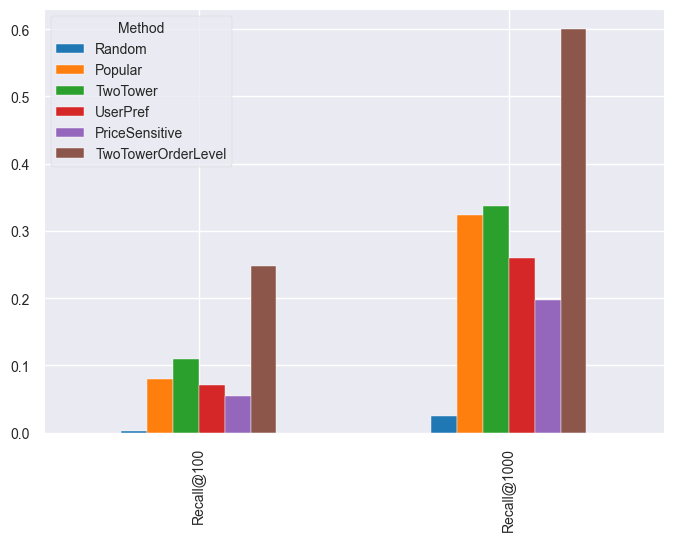

In [290]:
metrics_df.set_index('Method').T.astype('float').plot.bar()

In [309]:
a = dict(sample_test_orders.iloc[1])

In [310]:
a['detail_desc'], a['article_id']

('5-pocket jeans in superstretch washed denim with a regular waist and super-skinny legs',
 '0554450001')

In [311]:
a['prev_items_desc'], a['prev_articles']

('5-pocket jeans in superstretch washed denim with a regular waist and super-skinny legs 5-pocket jeans in superstretch washed denim with a regular waist and super-skinny legs 5-pocket jeans in superstretch washed denim with a regular waist and super-skinny legs long-sleeved blouse in woven fabric with a collar v-neck buttons down the front buttoned cuffs and a rounded hem',
 '0554450001 0554450001 0554450001 0762846008')

In [327]:
test[['article_id','customer_id']].value_counts(normalize=True).cumsum()[:20000]

article_id  customer_id                                                     
0685814001  235b8dab472251f9551ed2123eeba1a8b3c599a164b38029a7fd526cae795be1    0.000113
0895555001  a53fc8b5c6307731d572d9980b38989307129034389b05840d3f8b340744459c    0.000210
0685813003  adf3525750248f1710a1bc8b045adbe04650c7ba3ed26244a6a0e3c3b2b0d907    0.000304
0677930023  b3273672028476e603e6b8ea82b83b2137b3c42c7a68131bf1acf4c19e6d23c5    0.000398
0685813003  a6c1c70b77da6e6a7979b8d3b16704081c4748420ab7db4238333396156b8e7a    0.000473
                                                                                  ...   
0877961011  41b78839b6921174b5bcc8180cb3512447c63c0909fc7c3fe6ee9a9032a86cbc    0.168679
0878190003  e55d5ddb3a0c3fb1b4df8edbf526ba12989ab2a852c72774e3f3338cbbb3335e    0.168686
0878190004  0276c032e517d9236caa9f0652ff89d99debb37e3135d170b728e3e724ce0a4a    0.168694
            0c25764d393fec727dded74e63af8e7364c6888e251f8d1165f17a2c3e3b7101    0.168701
            0d8a234182035dc4db0c2

In [319]:
train.shape

(1769097, 17)